PURPOSE: Classify 146 bills across 9 policy mechanism dimensions

PREREQUISITES: Run 03_data_completion.ipynb first

WHAT THIS DOES:
- Loads bills with completed metadata
- Classifies each bill on 9 policy mechanisms
- Assigns bills to policy paradigms
- Creates comprehensive analysis and visualizations
- Prepares for gap analysis against teen risks

OUTPUT: bill_classifications_full.csv with mechanisms + paradigms

In [2]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import yaml
import numpy as np
from anthropic import Anthropic
from collections import Counter

sns.set_style("whitegrid")
sns.set_palette("colorblind")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

print("✓ Libraries loaded")

✓ Libraries loaded


In [3]:
try:
    with open('../config.yml', 'r') as f:
        config = yaml.safe_load(f)
    
    api_key = config.get('ANTHROPIC_API_KEY')
    if not api_key:
        raise ValueError("ANTHROPIC_API_KEY not found in config.yml")
    
    print("✓ API key loaded from config.yml")
    
except FileNotFoundError:
    print("✗ config.yml not found in parent directory")
    print("  Create ../config.yml with:")
    print("  ANTHROPIC_API_KEY: sk-ant-your-key-here")
    raise
except Exception as e:
    print(f"✗ Error loading config: {e}")
    raise


✓ API key loaded from config.yml


In [4]:
df_bills = pl.read_csv('../data/bill_data_completed.csv')
print(f"✓ Loaded {len(df_bills):,} bills with completed metadata")

✓ Loaded 146 bills with completed metadata


In [5]:
MECHANISM_CLASSIFICATION_PROMPT = """You are analyzing US state child online safety legislation to classify policy mechanisms.

**Bill Information:**
State: {state}
Name: {name}
Description: {description}

---

## TASK: Classify Policy Mechanisms

Mark TRUE only if the mechanism is **explicitly required** by the bill. Mark FALSE if only mentioned, suggested, or optional.

**Definitions:**

1. **age_verification**: Bill REQUIRES platforms/websites to verify users are above minimum age (e.g., ID check, facial scan, third-party verification)

2. **parental_consent**: Bill REQUIRES parental permission/notification before minors can create accounts, access features, or share data

3. **data_collection_limits**: Bill RESTRICTS what personal data companies can collect, use, sell, or retain from minors (beyond general privacy laws)

4. **algorithmic_restrictions**: Bill REGULATES recommendation algorithms, autoplay, infinite scroll, or other addictive/engagement-maximizing features for minors

5. **duty_of_care**: Bill establishes LEGAL STANDARD requiring platforms to design products/services for child safety (affirmative obligation)

6. **risk_assessment_required**: Bill MANDATES platforms conduct and report safety risk assessments for children

7. **default_privacy_settings**: Bill REQUIRES privacy-protective settings by default for minor accounts (not just recommended)

8. **school_based**: Bill focuses on SCHOOLS (curricula, digital literacy training, school filtering/monitoring) rather than regulating platforms directly

9. **targets_all_platforms**: Bill applies to ALL online services/platforms (TRUE) vs. only specific categories like pornography sites (FALSE)

**Examples:**
- "Requires age verification to access pornography websites" → age_verification: true, targets_all_platforms: false
- "Prohibits selling personal data of users under 13" → data_collection_limits: true
- "Platforms must disable autoplay for minor accounts" → algorithmic_restrictions: true
- "Schools must teach digital literacy" → school_based: true
- "Creates task force to study online safety" → all false (procedural, not regulatory)

---

## OUTPUT FORMAT

Respond with ONLY valid JSON (no markdown, no explanation):

{{
  "mechanisms": {{
    "age_verification": true/false,
    "parental_consent": true/false,
    "data_collection_limits": true/false,
    "algorithmic_restrictions": true/false,
    "duty_of_care": true/false,
    "risk_assessment_required": true/false,
    "default_privacy_settings": true/false,
    "school_based": true/false,
    "targets_all_platforms": true/false
  }},
  "reasoning": "Brief explanation of classification"
}}

Be conservative. When uncertain, mark FALSE.
"""

print("✓ Prompt template ready")


✓ Prompt template ready


In [6]:
print("\n=== RUNNING MECHANISM CLASSIFICATION ===")
print("This will classify all 146 bills across 9 policy dimensions\n")

client = Anthropic(api_key=api_key)

mechanism_results = []
mechanism_errors = []

for i, bill in enumerate(df_bills.iter_rows(named=True), 1):
    print(f"[{i:3}/{len(df_bills)}] {bill['US State']:15} {bill['Name'][:45]}...")
    
    # Create mechanism classification prompt
    prompt = MECHANISM_CLASSIFICATION_PROMPT.format(
        state=bill['US State'],
        name=bill['Name'],
        description=bill['Description']
    )
    
    try:
        message = client.messages.create(
            model="claude-sonnet-4-20250514",
            max_tokens=800,
            temperature=0.0,
            messages=[{"role": "user", "content": prompt}]
        )
        
        text = message.content[0].text.strip()
        if text.startswith('```'):
            text = text.replace('```json', '').replace('```', '').strip()
        
        classification = json.loads(text)
        
        # Store results with metadata
        result = {
            'state': bill['US State'],
            'name': bill['Name'],
            'description': bill['Description'],
            'mechanisms': classification['mechanisms'],
            'reasoning': classification.get('reasoning', '')
        }
        
        mechanism_results.append(result)
        
        # Show which mechanisms are TRUE
        true_mechs = [k for k, v in classification['mechanisms'].items() if v]
        mechs_str = ', '.join(true_mechs) if true_mechs else 'None'
        print(f"     ✓ {mechs_str}")
        
    except Exception as e:
        print(f"     ✗ Error: {e}")
        mechanism_errors.append({
            'bill': f"{bill['US State']} - {bill['Name']}",
            'error': str(e)
        })

print(f"\n✓ Mechanism classification: {len(mechanism_results)}/{len(df_bills)} bills")
print(f"  Errors: {len(mechanism_errors)}")

# Save results
with open('../data/mechanism_classifications.json', 'w') as f:
    json.dump(mechanism_results, f, indent=2)
print("✓ Saved: ../data/mechanism_classifications.json")


=== RUNNING MECHANISM CLASSIFICATION ===
This will classify all 146 bills across 9 policy dimensions

[  1/146] Alabama         Relating to consumer protection;  to require ...
     ✓ None
[  2/146] Arizona         To create the protection of minors from distr...
     ✓ age_verification
[  3/146] Arkansas        To create the protection of minors from distr...
     ✓ age_verification, data_collection_limits
[  4/146] Arkansas        To create the social media safety act;  to re...
     ✓ age_verification, parental_consent, data_collection_limits
[  5/146] California      Business regulations: sexually explicit mater...
     ✓ age_verification, data_collection_limits
[  6/146] California      The California Age-Appropriate Design Code Ac...
     ✓ data_collection_limits, duty_of_care, risk_assessment_required, targets_all_platforms
[  7/146] California      Features that harm child users: civil penalty...
     ✓ algorithmic_restrictions, duty_of_care, risk_assessment_required
[  8/146]

In [7]:
# Create flat structure for analysis
rows = []
for completed, mechanisms in zip(df_bills.iter_rows(named=True), mechanism_results):
    row = {
        'state': completed['US State'],
        'name': completed['Name'],
        'description': completed['Description'],
        'issue_tag_1': completed['Issue_Tag_1'],
        'issue_tag_2': completed['Issue_Tag_2'],
        'issue_tag_3': completed['Issue_Tag_3'],
        'governance': completed['Governance']
    }
    
    # Add mechanism columns
    for mech, value in mechanisms['mechanisms'].items():
        row[mech] = value
    
    rows.append(row)

df_classified = pl.DataFrame(rows)

print(f"✓ Created classified dataset: {df_classified.shape}")

# Save as CSV
df_classified.write_csv('../data/bill_classifications.csv')
print("✓ Saved: ../data/bill_classifications.csv")

✓ Created classified dataset: (146, 16)
✓ Saved: ../data/bill_classifications.csv


In [8]:
print("\n\n=== POLICY MECHANISM ANALYSIS ===\n")

mechanism_names = {
    'age_verification': 'Age Verification',
    'parental_consent': 'Parental Consent',
    'data_collection_limits': 'Data Collection Limits',
    'algorithmic_restrictions': 'Algorithmic Restrictions',
    'duty_of_care': 'Duty of Care',
    'risk_assessment_required': 'Risk Assessment Required',
    'default_privacy_settings': 'Default Privacy Settings',
    'school_based': 'School-Based (Education)',
    'targets_all_platforms': 'Targets All Platforms'
}

print("Mechanism frequency across 146 bills:\n")

mech_counts = {}
for mech_key, mech_label in mechanism_names.items():
    count = df_classified[mech_key].sum()
    pct = count / len(df_classified) * 100
    mech_counts[mech_label] = count
    print(f"{mech_label:35} {count:3} bills ({pct:5.1f}%)")

# Calculate bills with multiple mechanisms
df_classified = df_classified.with_columns([
    pl.sum_horizontal([
        pl.col(mech).cast(pl.Int32) 
        for mech in mechanism_names.keys()
    ]).alias('total_mechanisms')
])

print(f"\n\nBills with NO mechanisms: {len(df_classified.filter(pl.col('total_mechanisms') == 0))}")
print(f"Bills with 1 mechanism: {len(df_classified.filter(pl.col('total_mechanisms') == 1))}")
print(f"Bills with 2+ mechanisms: {len(df_classified.filter(pl.col('total_mechanisms') >= 2))}")
print(f"Max mechanisms in single bill: {df_classified['total_mechanisms'].max()}")



=== POLICY MECHANISM ANALYSIS ===

Mechanism frequency across 146 bills:

Age Verification                     40 bills ( 27.4%)
Parental Consent                     24 bills ( 16.4%)
Data Collection Limits               70 bills ( 47.9%)
Algorithmic Restrictions             18 bills ( 12.3%)
Duty of Care                         13 bills (  8.9%)
Risk Assessment Required             20 bills ( 13.7%)
Default Privacy Settings             21 bills ( 14.4%)
School-Based (Education)             22 bills ( 15.1%)
Targets All Platforms                39 bills ( 26.7%)


Bills with NO mechanisms: 29
Bills with 1 mechanism: 31
Bills with 2+ mechanisms: 86
Max mechanisms in single bill: 5


In [9]:
print("\n\n=== ASSIGNING POLICY PARADIGMS ===\n")

def assign_paradigm(row):
    """Assign paradigm based on mechanism combination"""
    
    has_age_verify = row.get('age_verification', False)
    has_parental = row.get('parental_consent', False)
    has_data = row.get('data_collection_limits', False)
    has_algo = row.get('algorithmic_restrictions', False)
    has_duty = row.get('duty_of_care', False)
    has_risk = row.get('risk_assessment_required', False)
    has_privacy = row.get('default_privacy_settings', False)
    has_school = row.get('school_based', False)
    all_platforms = row.get('targets_all_platforms', False)
    
    total_mechs = sum([has_age_verify, has_parental, has_data, has_algo, 
                      has_duty, has_risk, has_privacy, has_school])
    
    # No mechanisms = procedural
    if total_mechs == 0:
        return 'Procedural/Study'
    
    # School-based
    if has_school and total_mechs == 1:
        return 'Educational'
    
    # Age verification only (often porn sites)
    if has_age_verify and total_mechs == 1:
        return 'Access Control'
    
    # Privacy-focused
    if has_data and not (has_duty or has_risk or has_algo):
        return 'Privacy Protection'
    
    # Platform responsibility (duty of care, risk assessment, algo restrictions)
    if (has_duty or has_risk or has_algo) and all_platforms:
        return 'Platform Responsibility'
    
    # Mixed/hybrid
    if total_mechs >= 3:
        return 'Comprehensive/Hybrid'
    
    # Default
    return 'Other/Mixed'

# Assign paradigms
paradigms = []
for row in df_classified.iter_rows(named=True):
    paradigms.append(assign_paradigm(row))

df_classified = df_classified.with_columns([
    pl.Series('paradigm', paradigms)
])

# Count paradigms
paradigm_counts = (
    df_classified
    .group_by('paradigm')
    .agg(pl.len().alias('count'))
    .sort('count', descending=True)
)

print("Bills by policy paradigm:\n")
print(paradigm_counts)

# Save final dataset with paradigms
df_classified.write_csv('../data/bill_classifications_full.csv')
print("\n✓ Saved: ../data/bill_classifications_full.csv")



=== ASSIGNING POLICY PARADIGMS ===

Bills by policy paradigm:

shape: (7, 2)
┌─────────────────────────┬───────┐
│ paradigm                ┆ count │
│ ---                     ┆ ---   │
│ str                     ┆ u32   │
╞═════════════════════════╪═══════╡
│ Privacy Protection      ┆ 50    │
│ Procedural/Study        ┆ 32    │
│ Platform Responsibility ┆ 22    │
│ Other/Mixed             ┆ 16    │
│ Educational             ┆ 13    │
│ Access Control          ┆ 8     │
│ Comprehensive/Hybrid    ┆ 5     │
└─────────────────────────┴───────┘

✓ Saved: ../data/bill_classifications_full.csv


✓ Saved: ../output/figures/mechanism_classification_analysis.png


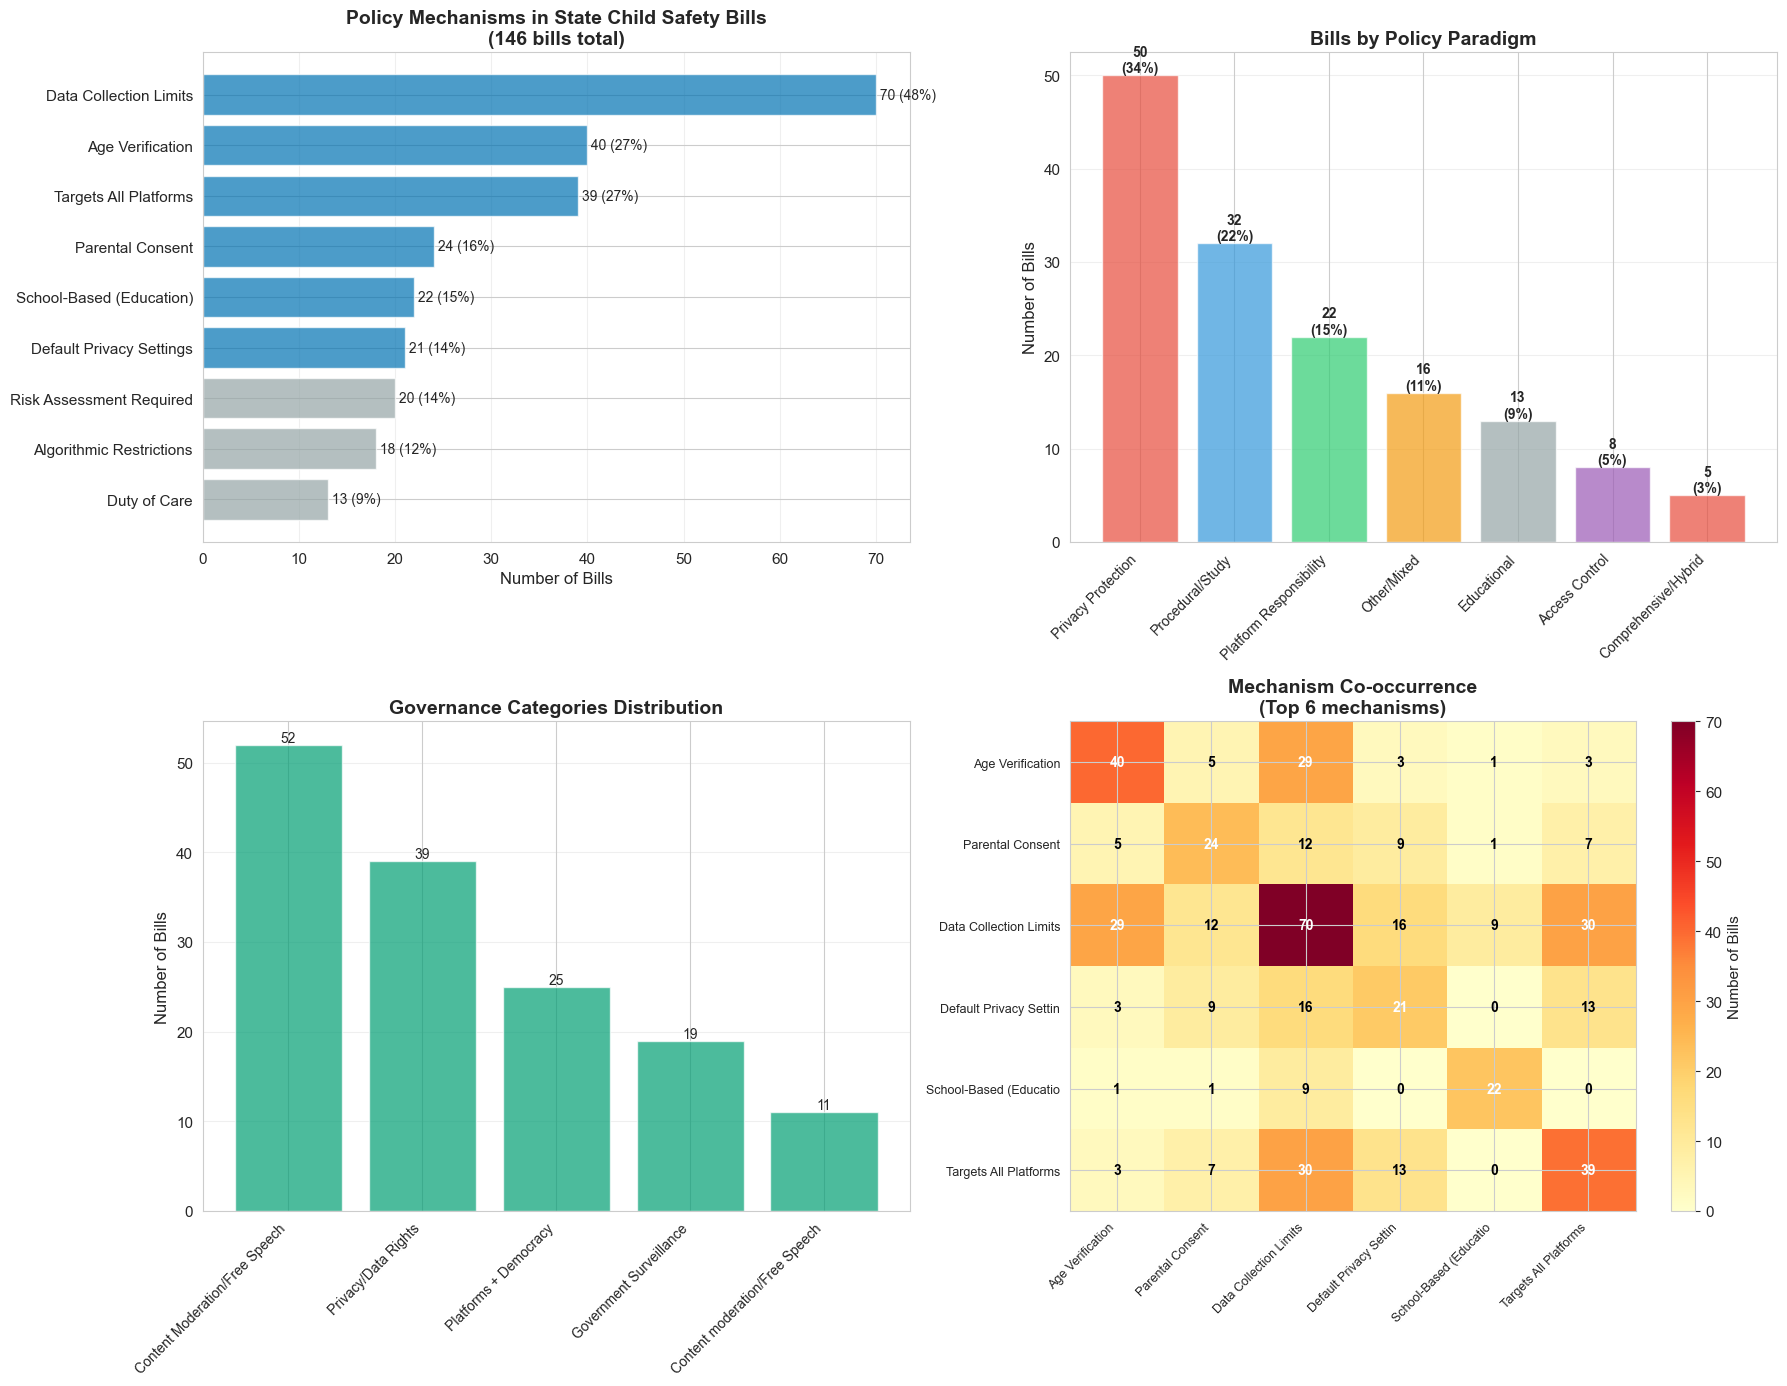

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Plot 1: Mechanism Frequency
ax1 = axes[0, 0]

sorted_mechs = sorted(mech_counts.items(), key=lambda x: x[1], reverse=True)
labels, counts = zip(*sorted_mechs)

colors = ['#0072B2' if c > 20 else '#95a5a6' for c in counts]
bars = ax1.barh(range(len(labels)), counts, color=colors, alpha=0.7)
ax1.set_yticks(range(len(labels)))
ax1.set_yticklabels(labels, fontsize=11)
ax1.invert_yaxis()
ax1.set_xlabel('Number of Bills', fontsize=12)
ax1.set_title('Policy Mechanisms in State Child Safety Bills\n(146 bills total)', 
              fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Add count labels
for i, (bar, count) in enumerate(zip(bars, counts)):
    pct = count / len(df_classified) * 100
    ax1.text(count, i, f' {count} ({pct:.0f}%)', va='center', fontsize=10)

# Plot 2: Paradigms
ax2 = axes[0, 1]

paradigm_labels = paradigm_counts['paradigm'].to_list()
paradigm_values = paradigm_counts['count'].to_list()

colors_paradigm = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#95a5a6', '#9b59b6']

bars = ax2.bar(range(len(paradigm_labels)), paradigm_values, 
               color=colors_paradigm[:len(paradigm_labels)], alpha=0.7)
ax2.set_xticks(range(len(paradigm_labels)))
ax2.set_xticklabels(paradigm_labels, rotation=45, ha='right', fontsize=10)
ax2.set_ylabel('Number of Bills', fontsize=12)
ax2.set_title('Bills by Policy Paradigm', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

for bar, count in zip(bars, paradigm_values):
    pct = count / len(df_classified) * 100
    ax2.text(bar.get_x() + bar.get_width()/2, count,
            f'{count}\n({pct:.0f}%)', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 3: Governance Distribution
ax3 = axes[1, 0]

gov_counts = (
    df_classified
    .group_by('governance')
    .agg(pl.len().alias('count'))
    .sort('count', descending=True)
)

gov_labels = [g if g else 'Unlabeled' for g in gov_counts['governance'].to_list()]
gov_values = gov_counts['count'].to_list()

bars = ax3.bar(range(len(gov_labels)), gov_values, color='#009E73', alpha=0.7)
ax3.set_xticks(range(len(gov_labels)))
ax3.set_xticklabels(gov_labels, rotation=45, ha='right', fontsize=10)
ax3.set_ylabel('Number of Bills', fontsize=12)
ax3.set_title('Governance Categories Distribution', fontsize=14, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

for bar, count in zip(bars, gov_values):
    ax3.text(bar.get_x() + bar.get_width()/2, count,
            f'{count}', ha='center', va='bottom', fontsize=10)

# Plot 4: Mechanism Co-occurrence Heatmap
ax4 = axes[1, 1]

# Get top 6 mechanisms
top_6_mechs = sorted_mechs[:6]
mech_keys = [k for k, v in mechanism_names.items() 
             if mechanism_names[k] in [m[0] for m in top_6_mechs]]

# Calculate co-occurrence matrix
corr_matrix = []
for m1 in mech_keys:
    row = []
    for m2 in mech_keys:
        both = len(df_classified.filter(
            (pl.col(m1) == True) & (pl.col(m2) == True)
        ))
        row.append(both)
    corr_matrix.append(row)

corr_matrix = np.array(corr_matrix)

im = ax4.imshow(corr_matrix, cmap='YlOrRd', aspect='auto')

# Labels
short_labels = [mechanism_names[k][:22] for k in mech_keys]
ax4.set_xticks(range(len(short_labels)))
ax4.set_yticks(range(len(short_labels)))
ax4.set_xticklabels(short_labels, rotation=45, ha='right', fontsize=9)
ax4.set_yticklabels(short_labels, fontsize=9)
ax4.set_title('Mechanism Co-occurrence\n(Top 6 mechanisms)', 
              fontsize=14, fontweight='bold')

# Add counts to cells
for i in range(len(short_labels)):
    for j in range(len(short_labels)):
        text = ax4.text(j, i, int(corr_matrix[i, j]),
                      ha="center", va="center", 
                      color="black" if corr_matrix[i, j] < 20 else "white", 
                      fontsize=10, fontweight='bold')

plt.colorbar(im, ax=ax4, label='Number of Bills')

plt.tight_layout()
plt.savefig('../output/figures/mechanism_classification_analysis.png', dpi=300, bbox_inches='tight')
print("✓ Saved: ../output/figures/mechanism_classification_analysis.png")
plt.show()

In [11]:
print("\n\n" + "="*70)
print("MECHANISM CLASSIFICATION SUMMARY")
print("="*70)

print(f"\nProcessed: {len(df_classified)} bills")

print(f"\nTop 5 Mechanisms:")
for label, count in sorted_mechs[:5]:
    pct = count / len(df_classified) * 100
    print(f"  • {label}: {count} bills ({pct:.0f}%)")

print(f"\nPolicy Paradigms:")
for row in paradigm_counts.iter_rows(named=True):
    pct = row['count'] / len(df_classified) * 100
    print(f"  • {row['paradigm']}: {row['count']} bills ({pct:.0f}%)")

print(f"\nMechanism Complexity:")
print(f"  • No mechanisms: {len(df_classified.filter(pl.col('total_mechanisms') == 0))} bills")
print(f"  • Single mechanism: {len(df_classified.filter(pl.col('total_mechanisms') == 1))} bills")
print(f"  • Multiple mechanisms: {len(df_classified.filter(pl.col('total_mechanisms') >= 2))} bills")

# Find bills with most mechanisms
max_mechs = df_classified['total_mechanisms'].max()
complex_bills = df_classified.filter(pl.col('total_mechanisms') == max_mechs)
print(f"\nMost complex bill ({max_mechs} mechanisms):")
for row in complex_bills.head(1).iter_rows(named=True):
    print(f"  • {row['state']}: {row['name'][:60]}")



MECHANISM CLASSIFICATION SUMMARY

Processed: 146 bills

Top 5 Mechanisms:
  • Data Collection Limits: 70 bills (48%)
  • Age Verification: 40 bills (27%)
  • Targets All Platforms: 39 bills (27%)
  • Parental Consent: 24 bills (16%)
  • School-Based (Education): 22 bills (15%)

Policy Paradigms:
  • Privacy Protection: 50 bills (34%)
  • Procedural/Study: 32 bills (22%)
  • Platform Responsibility: 22 bills (15%)
  • Other/Mixed: 16 bills (11%)
  • Educational: 13 bills (9%)
  • Access Control: 8 bills (5%)
  • Comprehensive/Hybrid: 5 bills (3%)

Mechanism Complexity:
  • No mechanisms: 29 bills
  • Single mechanism: 31 bills
  • Multiple mechanisms: 86 bills

Most complex bill (5 mechanisms):
  • Connecticut: An act concerning online privacy, data and safety protection
